In [ ]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import class_weight

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Conv1D, GlobalMaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

2025-05-11 12:50:23.738132: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-11 12:50:23.749622: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-11 12:50:23.753036: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-11 12:50:23.761895: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
# Charge npy files
def charge_npy(path):
    X = np.load(path)
    y = np.load(path.replace('X', 'y'))
    return X, y

In [24]:
# Charge embeddings of Facenet for Train, Val and Test
path_train = '../../../../Facenet Embeddings/Train/X_train.npy'
path_val   = '../../../../Facenet Embeddings/Val/X_val.npy'
path_test  = '../../../../Facenet Embeddings/Test/X_test.npy'
X_train, y_train = charge_npy(path_train)
X_val, y_val = charge_npy(path_val)
X_test, y_test = charge_npy(path_test)

n_frames = 5
embedding_dim = 128

X_train = X_train.reshape((-1, n_frames, embedding_dim))
y_train = y_train[:, 4:8]
y_train = np.mean(y_train.reshape(-1, 5, 4), axis=1)
y_train = np.argmax(y_train, axis=1)

X_val = X_val.reshape((-1, n_frames, embedding_dim)) 
y_val = y_val[:, 4:8]
y_val = np.mean(y_val.reshape(-1, 5, 4), axis=1)
y_val = np.argmax(y_val, axis=1)

X_test = X_test.reshape((-1, n_frames, embedding_dim))  
y_test = y_test[:, 4:8]
y_test = np.mean(y_test.reshape(-1, 5, 4), axis=1)
y_test = np.argmax(y_test, axis=1)

X = np.concatenate((X_val, X_test), axis=0)
y = np.concatenate((y_val, y_test), axis=0)

In [25]:
# Divide data in Val and test
X_val, X_test, y_val, y_test = train_test_split(X, y, test_size=0.5, random_state=123, stratify=y)
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((5481, 5, 128), (1721, 5, 128), (1722, 5, 128), (5481,), (1721,), (1722,))

In [28]:
# Calculate class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))
class_weights

{0: 40.3014705882353,
 1: 6.40303738317757,
 2: 0.5172706681766704,
 3: 0.5302825077399381}

In [ ]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=250, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=100, verbose=1)

# CNN model
def build_cnn_model(input_shape):
    model = Sequential()
    model.add(Conv1D(128, kernel_size=5, activation='relu', padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    
    model.add(Conv1D(256, kernel_size=3, activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    
    model.add(Conv1D(256, kernel_size=3, activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(GlobalMaxPooling1D())

    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(4, activation='softmax'))  # Cambia 4 por el número de clases que tengas

    model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(0.0005), metrics=['accuracy'])
    return model

# Create and train the CNN model
model = build_cnn_model((X_train.shape[1], X_train.shape[2]))
    
history = model.fit(
    X_train,
    y_train,
    class_weight=class_weights,
    epochs=1000,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

/root/miniconda3/envs/tf-gpu2/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1746986577.136299    7631 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1746986577.172677    7631 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1746986577.172742    7631 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1746986577.176228    7631 cuda

Epoch 1/1000


I0000 00:00:1746986580.714209    9284 service.cc:146] XLA service 0x7f5fe8005440 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746986580.714244    9284 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2025-05-11 13:03:00.759237: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-05-11 13:03:01.061389: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90101


 21/172 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4168 - loss: 2.3261

I0000 00:00:1746986588.916786    9284 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


172/172 ━━━━━━━━━━━━━━━━━━━━ 16s 34ms/step - accuracy: 0.3480 - loss: 2.5795 - val_accuracy: 0.2807 - val_loss: 1.4355 - learning_rate: 5.0000e-04
Epoch 2/1000
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3240 - loss: 1.6159 - val_accuracy: 0.2516 - val_loss: 1.4673 - learning_rate: 5.0000e-04
Epoch 3/1000
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3224 - loss: 1.3290 - val_accuracy: 0.2847 - val_loss: 1.4210 - learning_rate: 5.0000e-04
Epoch 4/1000
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3425 - loss: 1.2904 - val_accuracy: 0.2493 - val_loss: 1.3968 - learning_rate: 5.0000e-04
Epoch 5/1000
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3353 - loss: 1.3212 - val_accuracy: 0.2185 - val_loss: 1.5941 - learning_rate: 5.0000e-04
Epoch 6/1000
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3377 - loss: 1.2683 - val_accuracy: 0.2260 - val_loss: 1.6333 - learning_rate: 5.0000e-04
Epoch 7/1000
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accurac

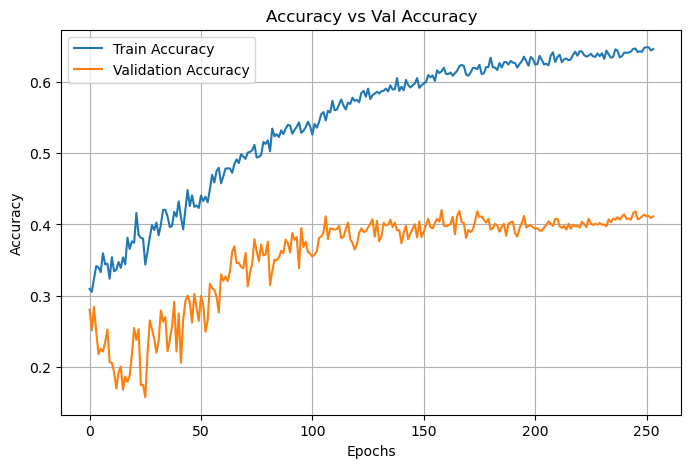

In [30]:
# Train Accuracy vs Val Accuracy 
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title(f'Accuracy vs Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

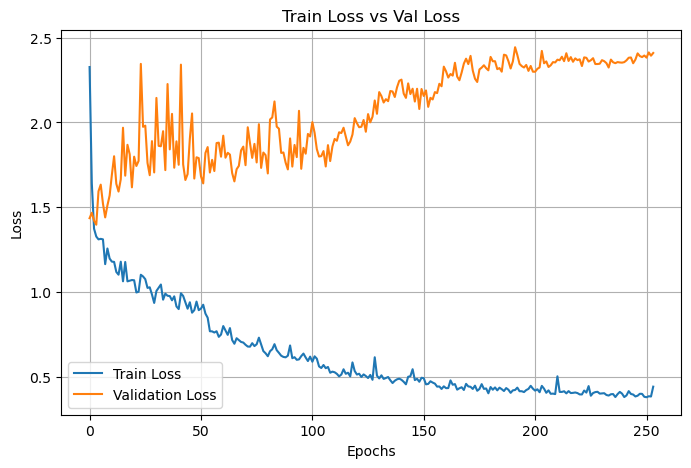

In [31]:
# Train Loss vs Validation Loss
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'Train Loss vs Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [32]:
# Predictions
preds = model.predict(X_test)
final_preds = np.argmax(preds, axis=1)

54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


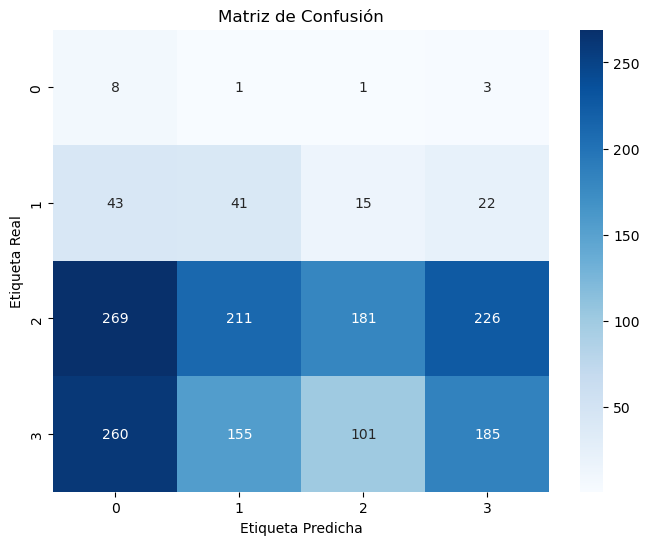

In [33]:
# Confusion matrix
cm = confusion_matrix(y_test, final_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.arange(cm.shape[1]), yticklabels=np.arange(cm.shape[0]))
plt.title("Matriz de Confusión")
plt.xlabel("Etiqueta Predicha")
plt.ylabel("Etiqueta Real")
plt.show()

In [34]:
# Classification report
print(classification_report(y_test, final_preds, digits=3))

              precision    recall  f1-score   support

           0      0.014     0.615     0.027        13
           1      0.100     0.339     0.155       121
           2      0.607     0.204     0.305       887
           3      0.424     0.264     0.325       701

    accuracy                          0.241      1722
   macro avg      0.286     0.356     0.203      1722
weighted avg      0.493     0.241     0.301      1722



In [35]:
# UAR metric
def uar(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    uar = np.mean(np.diag(cm) / np.sum(cm, axis=1))
    return uar

uar_score = uar(y_test, final_preds)
print(f'UAR: {uar_score:.4f}')

UAR: 0.3555
